## VRP
reference: 
- https://en.wikipedia.org/wiki/Vehicle_routing_problem
- https://www.zhihu.com/question/275293660

![image](Figure_illustrating_the_vehicle_routing_problem.png)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def generate_data():
    size = 10
    X = np.random.random(size)
    Y = np.random.random(size)

    plt.figure('data')
    plt.scatter(X,Y,alpha=0.25)
    plt.show()

    data = pd.DataFrame({'X':X, 'Y':Y})
    data.index.name = 'id'
    data.head()
    data.to_csv('data/coordnates.csv')

generate_data()

<Figure size 640x480 with 1 Axes>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
coordinates = pd.read_csv('data/coordnates.csv')
coordinates = {str(int(_id)):(x,y) for _id, x, y in coordinates[['id', 'X', 'Y']].values}
coordinates

{'0': (0.11603605929583127, 0.9941965399631238),
 '1': (0.8594888316987958, 0.0952112031629413),
 '2': (0.3262448111718511, 0.7496391875884506),
 '3': (0.5478572012878757, 0.009864960635934006),
 '4': (0.9738745664565852, 0.020673631172380857),
 '5': (0.07598615866175451, 0.10569418788519436),
 '6': (0.13825151492393772, 0.43471761522063934),
 '7': (0.7214609415071798, 0.14107514939153232),
 '8': (0.4971889910703252, 0.5613621086812528),
 '9': (0.3848029479088512, 0.09399752681566996)}

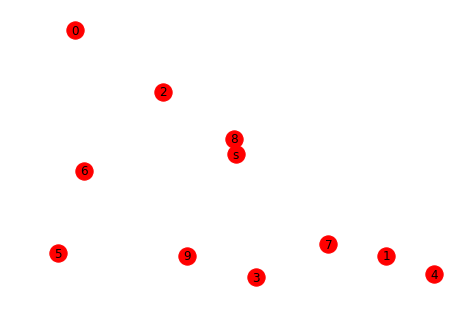

In [3]:
import networkx as nx
coordinates['s'] = (0.5, 0.5)
graph = nx.Graph()
graph.add_nodes_from(coordinates.keys())
nx.draw(graph, coordinates, with_labels=True)

In [4]:
from functools import lru_cache
from math import sqrt
import debug_tools
import time

#p2p refers to point to point
@lru_cache(15*15)
def get_p2p_distance(point1:str, point2:str):
    global coordinates
    x1, y1 = coordinates[point1]
    x2, y2 = coordinates[point2]
    return sqrt((x1-x2)**2 + (y1-y2)**2)

# @debug_tools.debug_print
def visulize_trace(trace):
    global coordinates
    edges = {s:[e] for s, e in trace}
    graph = nx.DiGraph(edges)
    graph.add_nodes_from(coordinates.keys())
    nx.draw(graph, coordinates, with_labels=True)
    plt.show()

## TSP Dynamic Programming solution

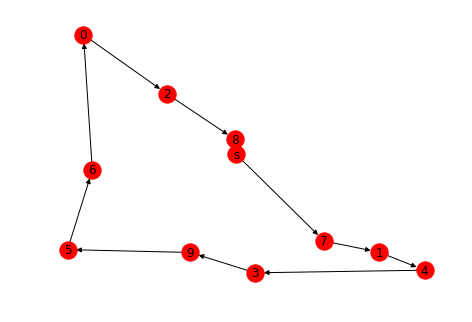

[('s', '7'), ('7', '1'), ('1', '4'), ('4', '3'), ('3', '9'), ('9', '5'), ('5', '6'), ('6', '0'), ('0', '2'), ('2', '8'), ('8', 's')]
3.155395014171804


In [5]:
class route:
    def __init__(self, trace):
        global coordinates
        self.trace  = trace # a list of tuple (edges)
        self.length = sum([get_p2p_distance(*e) for e in trace])
    
    def add(self, node):
        end_of_trace = self.trace[-1][-1]
        new_route = route([])
        new_route.trace = self.trace  + [(end_of_trace, node)]
        new_route.length = self.length + get_p2p_distance(end_of_trace, node)
        return new_route

debug_tools.stack_level = 0

@lru_cache(maxsize=10**10)
def opt_route(need_visited, end):
    # need_visited is a set of node
    if len(need_visited) == 1:
        return route([('s', end)])
    else:
        S = tuple([n for n in need_visited if n!=end])
        routes = [opt_route(S, n).add(end) for n in S]
        return min(routes, key=lambda r: r.length)


need_visited = tuple([e for e in coordinates.keys() if e != 's'])
best_route = opt_route(need_visited,'s')
visulize_trace(best_route.trace)
print(best_route.trace)
print(best_route.length)

In [6]:
from itertools import chain, combinations

def power_set(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

class route_group:
    def __init__(self, routes:list):
        self.routes = routes
        self.length = 0 if routes==[] else sum([r.length for r in routes])
        
    def add(self, r):
        new_group = route_group([])
        if type(r)==route:
            new_group.routes = self.routes + [r]
        else:
            new_group.routes = self.routes + r.routes
        new_group.length = self.length + r.length
        return new_group
    
    def print_group(self):
        print([r.trace for r in self.routes])

def tsp(U):
    if U:
        return opt_route(U,'s')
    else:
        return route([])

# @debug_tools.debug_print
@lru_cache(maxsize=10**10)
def vrp(U, k):
    if k==1:
        return route_group([tsp(U)])
    else:
        groups = []
        for u in power_set(U):
            group = route_group([])
            complementary_set = tuple([n for n in U if n not in u])
            group = group.add(vrp(complementary_set, k-1).add(tsp(u)))
            groups.append(group)
#             min(groups, key=lambda g: g.length).print_group()
            
        return min(groups, key=lambda g: g.length)


need_visited = tuple([e for e in coordinates.keys() if e != 's'])
best_route = vrp(need_visited,3)
#visulize_trace(best_route.trace)
best_route.routes

In [10]:
best_route.print_group()

[[('s', '7'), ('7', '1'), ('1', '4'), ('4', '3'), ('3', '9'), ('9', '5'), ('5', '6'), ('6', '8'), ('8', 's')], [('s', 's')], [('s', 's')]]


In [8]:
best_route.length

2.399312170222813